In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir("C:\\repos\\dr-crc-calibration\\src")
import configs as c
import markov as m

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_vs_target_sns(curr_log, target_inc=c.seer_inc, title="CRC Incidence by Stage"):
    """
    Plot model vs. SEER target cancer incidence by stage using Seaborn styling.

    Args:
        curr_log (tuple): Output log from run_markov (includes inc_adj).
        target_inc (pd.DataFrame): DataFrame with columns ['Age', 'Local Rate', 'Regional Rate', 'Distant Rate'].
        title (str): Plot title.
    """
    fig, ax = plt.subplots(figsize=(10,6))
    sns.set(style="whitegrid")
    inc_adj, _, _, _ = curr_log
    inc_adj = inc_adj[:, :65]
    x_values = np.arange(20, 85)

    # Color palette
    colors = {
        "Local": "#004600" , # "#003c00", #"#228B22",     # Green
        "Regional": "#0F85A0",  # Teal
        "Distant": "#DD4124"    # Red-Orange
    }


    # Plot target (dotted)
    ax.plot(target_inc["Age"], target_inc["Local Rate"], label="Local (Target)", color=colors["Local"], linestyle="dotted", linewidth=2.2)
    ax.plot(target_inc["Age"], target_inc["Regional Rate"], label="Regional (Target)", color=colors["Regional"], linestyle="dotted", linewidth=2.2)
    ax.plot(target_inc["Age"], target_inc["Distant Rate"], label="Distant (Target)", color=colors["Distant"], linestyle="dotted", linewidth=2.2)

    # Plot model (solid)
    ax.plot(x_values, inc_adj[6, :], label="Local (Model)", color=colors["Local"], linestyle="solid", linewidth=2.2)
    ax.plot(x_values, inc_adj[7, :], label="Regional (Model)", color=colors["Regional"], linestyle="solid", linewidth=2.2)
    ax.plot(x_values, inc_adj[8, :], label="Distant (Model)", color=colors["Distant"], linestyle="solid", linewidth=2.2)

    # Labels and title
    plt.title(title, fontsize=15)
    plt.xlabel("Age (Years)", fontsize=12)
    plt.ylabel("CRC Incidence per 100,000", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Legend with title
    legend = plt.legend(title="Stage & Source", fontsize=10, title_fontsize=11, loc="upper left")
    legend.get_title().set_ha('left')

    # Grid and layout
    plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    return fig

In [38]:
tmat_us = np.load("../out/US/bc/tmats/20240923_1243_tmat.npy")
log_us = m.run_markov_new(tmat_us, max_age=c.max_age)
tmat_dr_seer = np.load("../out/DR/SEER_I1_P1/tmats/20240923_1746_tmat.npy")
log_dr_seer = m.run_markov_new(tmat_dr_seer, max_age=c.max_age)
tmat_dr_hgps = np.load("../out/DR/HGPS_I1_P1/tmats/20240924_2148_tmat.npy")
log_dr_hgps = m.run_markov_new(tmat_dr_hgps, max_age=c.max_age)

In [44]:
hgps_stage_dist = pd.read_excel("../data/incidence_dr_globocan.xlsx", sheet_name="HGPS Stage")["Percent"]
dr_inc_stage = pd.read_excel("../data/incidence_dr_globocan.xlsx", sheet_name="DR incidence factor")
dr_total_inc = pd.read_csv("../data/dr_inc_splined.csv")["Rate"]
dr_seer_inc = c.load_seer_incidence(dr_inc_stage)
dr_hgps_inc = c.load_stage_distribution(dr_total_inc, hgps_stage_dist)

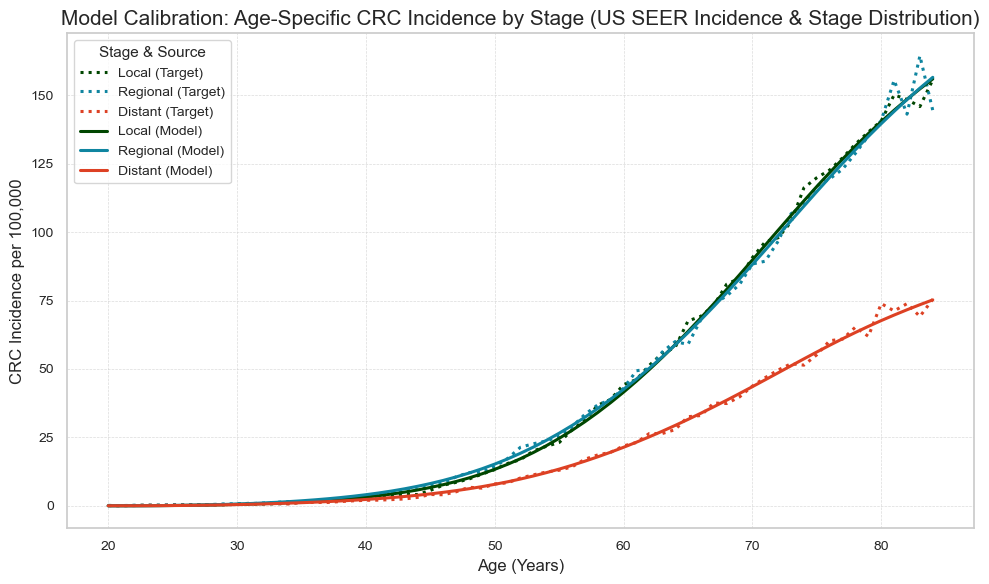

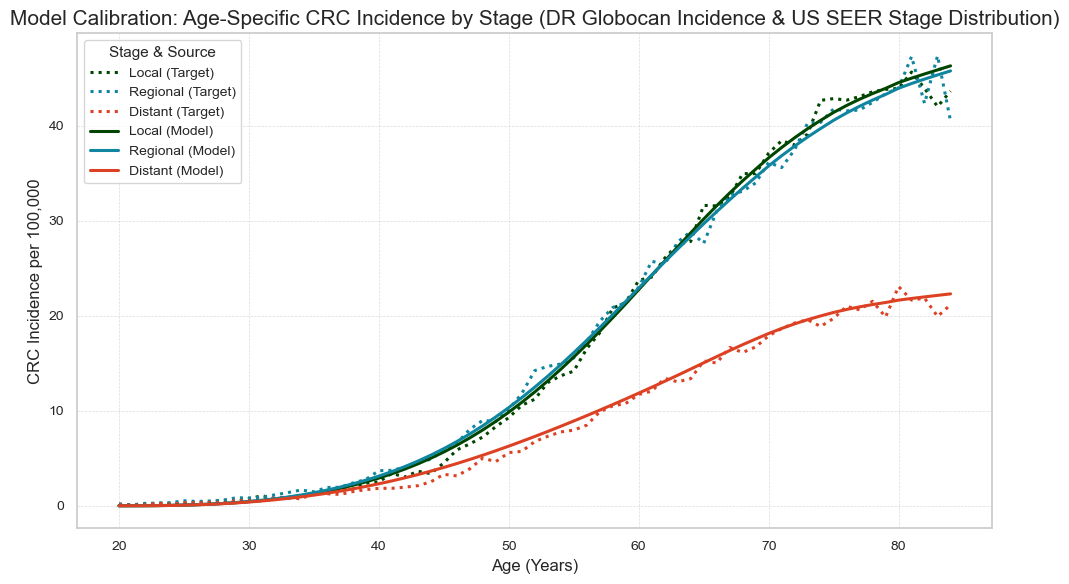

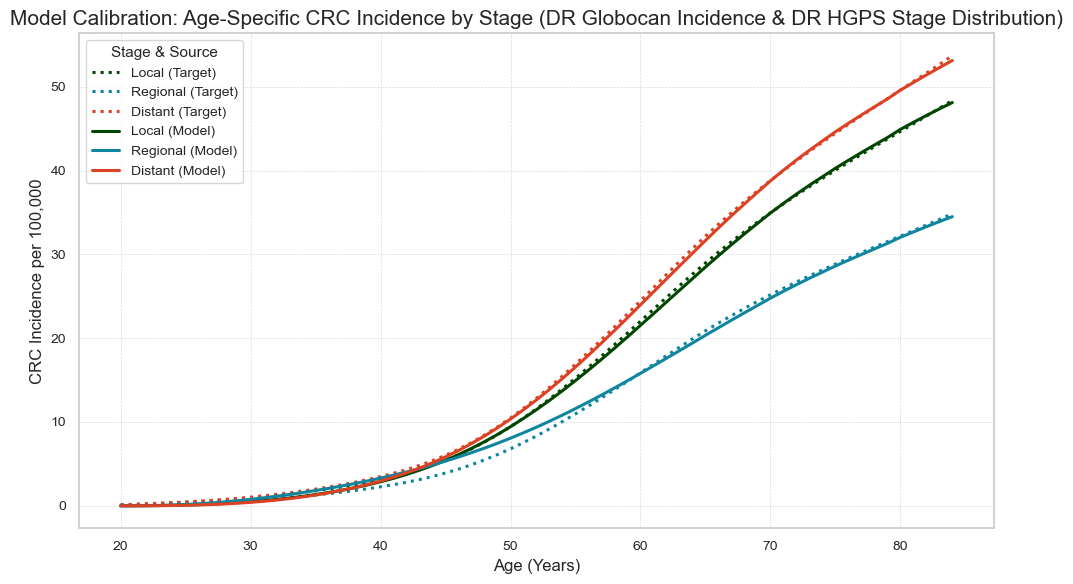

In [48]:
c.model_version, c.stage = "US", "SEER"
fig1 = plot_vs_target_sns(log_us, title="Model Calibration: Age-Specific CRC Incidence by Stage (US SEER Incidence & Stage Distribution)")
c.model_version = "DR"
fig2 = plot_vs_target_sns(log_dr_seer, target_inc = dr_seer_inc, title="Model Calibration: Age-Specific CRC Incidence by Stage (DR Globocan Incidence & US SEER Stage Distribution)")
c.stage = "HGPS"
fig3 = plot_vs_target_sns(log_dr_hgps, target_inc = dr_hgps_inc, title="Model Calibration: Age-Specific CRC Incidence by Stage (DR Globocan Incidence & DR HGPS Stage Distribution)")

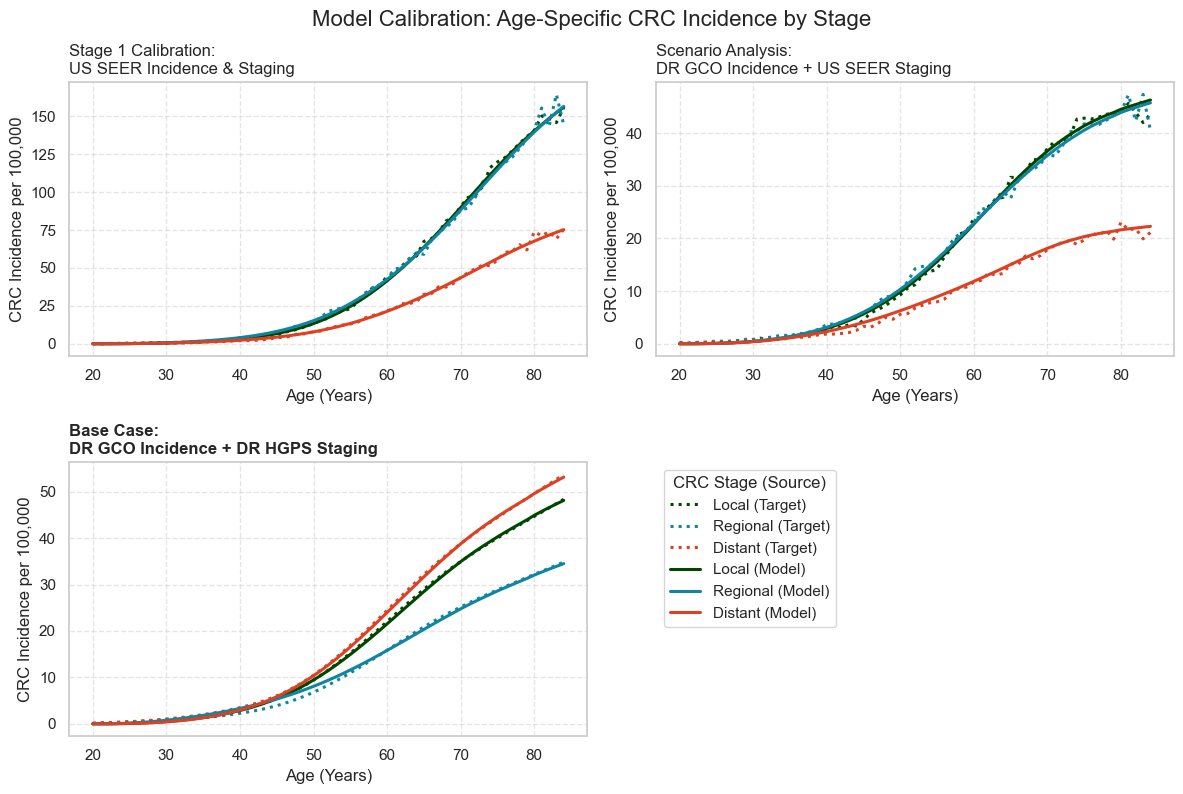

In [67]:
import matplotlib.pyplot as plt

# Create a 2x2 layout: we'll use the top-right panel for the legend only
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
figs = [fig1, fig2, fig3, None]
titles = [
    "Stage 1 Calibration:\nUS SEER Incidence & Staging",
    "Scenario Analysis:\nDR GCO Incidence + US SEER Staging",
    "Base Case:\nDR GCO Incidence + DR HGPS Staging",
    ""  # legend
]


for i, (ax, src_fig, title) in enumerate(zip(axs.flat, figs, titles)):
    if src_fig is not None:
        src_ax = src_fig.axes[0]
        for line in src_ax.lines:
            ax.plot(
                line.get_xdata(), line.get_ydata(),
                label=line.get_label(),
                color=line.get_color(),
                linestyle=line.get_linestyle(),
                linewidth=line.get_linewidth()
            )
        ax.set_title(title, fontsize=12, loc='left', fontweight='bold' if i == 2 else 'normal')
        ax.set_xlabel("Age (Years)", fontsize=12)
        ax.set_ylabel("CRC Incidence per 100,000", fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.5)

    else:
        ax.axis('off')  # hide top-right panel

# Place legend in top-right
handles, labels = axs[0, 0].get_legend_handles_labels()
legend_ax = axs[1, 1]
legend = legend_ax.legend(
    handles, labels,
    title="CRC Stage (Source)",
    fontsize=11,
    title_fontsize=12,
    loc="upper left",
    markerscale=2
)
legend_ax.get_legend().get_title().set_ha('left')

# Main figure title
plt.suptitle("Model Calibration: Age-Specific CRC Incidence by Stage", fontsize=16, y=0.99)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()